<a href="https://colab.research.google.com/github/garliccat/james_bond_predict/blob/master/James_Bond_ru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><font color="black" size="+4">Анализ Джеймсов Бондов</font></b>

<b><font color="black" size="+3">И скромная попытка подумать над новым No Time To Die</font></b>

Датасет для визуализаций и аналитики собран из разных источников прямо руками.

Датасет для обучения модели взят с [KAGGLE](https://www.kaggle.com/carolzhangdc/imdb-5000-movie-dataset)

In [1]:
#@title Загрузка библиотек и датасета.

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import seaborn as sns

![ -f datasets.zip ] && rm -f datasets.zip
!gdown https://drive.google.com/uc?id=1lS7YfRQ1FvVjbAyGkgNcyynEiUZ90CEO
!unzip datasets.zip
%cd datasets/
!ls

sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Downloading...
From: https://drive.google.com/uc?id=1lS7YfRQ1FvVjbAyGkgNcyynEiUZ90CEO
To: /content/datasets.zip
100% 560k/560k [00:00<00:00, 37.4MB/s]
Archive:  datasets.zip
   creating: datasets/
  inflating: datasets/ratings.csv    
  inflating: datasets/movie_metadata.csv  
/content/datasets
movie_metadata.csv  ratings.csv


### Загружаем маленький датасет с информацией о фильмах.

In [2]:
df = pd.read_csv("ratings.csv")
df = df.iloc[:-1, :]

print(df.columns)

Index(['title', 'year', 'actor', 'director', 'writer', 'producer', 'gross',
       'budget', 'imdb', 'dir_awg_imdb', 'act_awg_imdb', 'writer_awg_imdb',
       'prod_awg_imdb'],
      dtype='object')


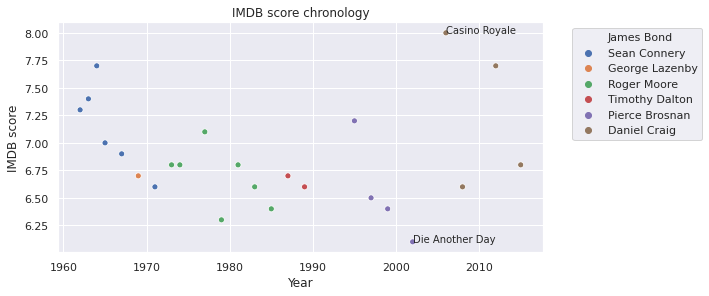

In [3]:
#@markdown ### Хронология фильмов / оценки IMDB, указанны лучший/худший фильмы.
plt.figure(figsize=(10, 4))
sns.scatterplot(
    x="year",
    y="imdb",
    hue="James Bond",
    data=df.rename(columns={"actor": "James Bond"})
    )
plt.legend(bbox_to_anchor=(1.05, 1))
plt.text(
    x=df[df["imdb"] == df["imdb"].max()]["year"].values[0],
    y=df[df["imdb"] == df["imdb"].max()]["imdb"].values[0],
    s=df[df["imdb"] == df["imdb"].max()]["title"].values[0]
    )
plt.text(
    x=df[df["imdb"] == df["imdb"].min()]["year"].values[0],
    y=df[df["imdb"] == df["imdb"].min()]["imdb"].values[0],
    s=df[df["imdb"] == df["imdb"].min()]["title"].values[0]
    )

plt.tight_layout()
plt.title("IMDB score chronology")
plt.xlabel("Year")
plt.ylabel("IMDB score")
plt.savefig("imdb_date.png")

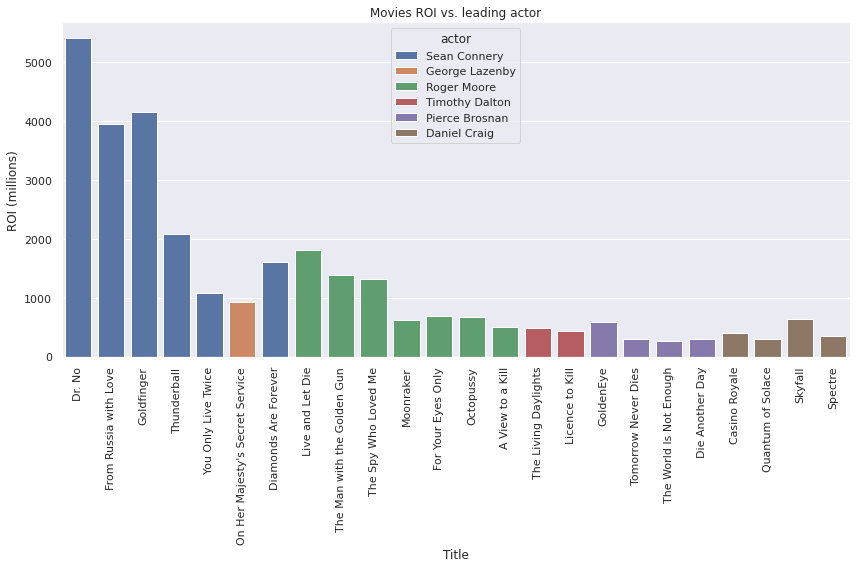

In [4]:
#@markdown ### Прибыль от фильмов (без учёта инфляции) / Актёры
df["gross"] = df["gross"] * 1000000
df["budget"] = df["budget"] * 1000000
df["roi"] = df["gross"] / df["budget"] * 100

plt.figure(figsize=(12, 8))
sns.barplot(
    x="title",
    y="roi",
    data=df,
    # data=df.sort_values(by="roi", ascending=False),
    hue="actor",
    dodge=False
    )
plt.xticks(rotation=90)
plt.ylabel('ROI (millions)')
plt.xlabel('Title')
plt.title('Movies ROI vs. leading actor')
plt.tight_layout()
plt.savefig('roi_dist.png')

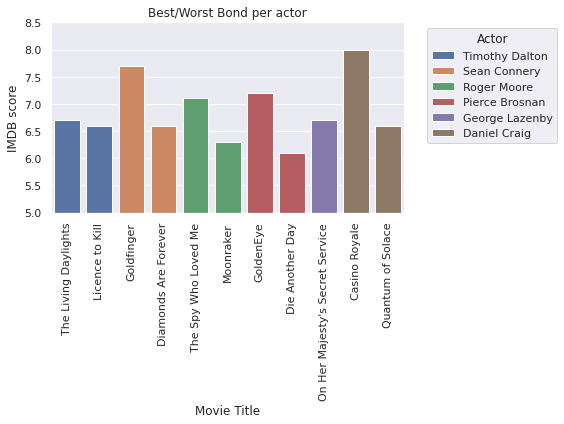

In [5]:
#@markdown ### Лучший / Худший фильм у каждого из актёров
idx = df.groupby(['actor'])['imdb']
imdb_min = idx.transform(min)
imdb_max = idx.transform(max)
actor_wb = df[(df['imdb'] == imdb_min) | (df['imdb'] == imdb_max)][['actor', 'title', 'imdb']].sort_values(by=['actor', 'imdb'], ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(
    x="title",
    y="imdb",
    data=actor_wb.rename(columns={"actor": "James Bond"}),
    # data=df.sort_values(by="roi", ascending=False),
    hue="James Bond",
    dodge=False
)

plt.xticks(rotation=90)
plt.legend(title='Actor', bbox_to_anchor=(1.05, 1))
plt.ylim(5, 8.5)
plt.xlabel('Movie Title')
plt.ylabel('IMDB score')
plt.title('Best/Worst Bond per actor')
plt.tight_layout()

Model score:  0.5243155903847301

Лучшие гиперпараметры модели:  {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 50}
No Time To Die predicted IMDB score:  [7.45122879]


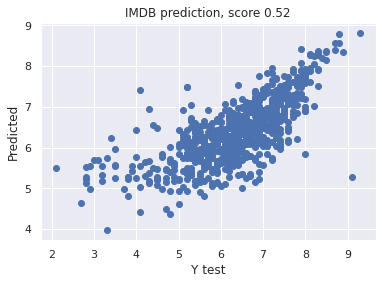

In [6]:
#@markdown ### Попытка предсказать оценку No Time To Die
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

np.random.seed(100)

df = pd.read_csv('movie_metadata.csv', encoding='ISO-8859-1')

df = df[['num_critic_for_reviews', 'country', 'director_facebook_likes', 'actor_1_facebook_likes',
		 'num_voted_users', 'num_user_for_reviews', 'actor_2_facebook_likes', 'duration',
		 # 'gross', 
		 'budget', 'title_year', 'imdb_score',
		 'actor_3_facebook_likes', 'cast_total_facebook_likes', 'facenumber_in_poster', 'movie_facebook_likes', 'content_rating'
		 ]]

# оставляем только фильмы из США и Великобритании, остальное кино в данном случае не релевантно
df = df.loc[(df['country'] == 'USA') | (df['country'] == 'UK')]

# переводим две категоризационные фичи в численный формат
df = pd.get_dummies(df, 
	prefix='_',
	columns=['content_rating', 'country'])

df = df.dropna()
X = df.drop('imdb_score', axis=1)
y = df['imdb_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# подбираем лучшие гиперпараметры случайного леса при помощи кросс-валидации
parameters = {
			  'n_estimators': range(50, 60, 10), 	# 50
			  'max_depth': range(10, 20), 			# 16
			  'min_samples_split': range(5, 10), 	# 8
			  'min_samples_leaf': range(2, 5)		# 2
			  }

search = GridSearchCV(estimator=RandomForestRegressor(),
                            # n_iter=10,
                            cv=5,
                            param_grid=parameters)

search.fit(X_train, y_train)

model_score = search.score(X_test, y_test)
print('Model score: ', model_score)
best_est = search.best_estimator_
best_params = search.best_params_
print('\nЛучшие гиперпараметры модели: ', best_params)

y_predict = best_est.predict(X_test)

plt.scatter(y_test, y_predict)
plt.xlabel('Y test')
plt.ylabel('Predicted')
plt.title('IMDB prediction, score {0:.2f}'.format(model_score))

# На данный момент у нас нет всех данных (фильм еще не вышел) но можно предположить многие из них.
# Число критиков можно взять от Skyfall, ибо он самый релевантный к нашему фильму
# Лайки страницы режиссера на фесбуке. У Фукунаги есть страница на фейсбуке, не совсем понятно насколько она валидна, но seems legit.
# Лайки фейсбука первого актера: полагаю что это лайки Дениэла Крейга. Но опять-таки, верифицированной страницы у него нет, поэтому предполагаем более или менее похожую на неё.
# Число оценивих пользователей: так же как и число проголосовавших критиков, возьмём цифры от Skyfall.
# Число пользователей с обзорами: рассматривая Skyfall и Spectre как референсные, возьмём 1000
# Лайки фейсбука второго актёра: Ну сам фильм пока никто не видел, поэтому можно только предполагать что речь тут о Рами Малеке, как протагонисте.
# Длительность: длительность пока не объявлена, но осмелимся предположить.
# Бюджет: бюджет мы знаем: 250 000 000
# Год выпуска: 2020
# Лайки третьего актера: по видимому имеется в виду девушка Бонда, в этом фильме её роль исполняет Леа Сейду, без верифицированной странички в фейсбуке, но какая-то есть.
# Общие лайки каста: тут не совсем понятно, но вроде как сумма лайков каста
# Количество лиц на постере: на всех постерах этого фильма (промо) один актёр.
# Лайки странички фильма в фейсбуке: возьмём официальную страницу франшизы.
# Соотношение сторон экрана: 2.39

X_validate = np.array([750, 2800, 115000, 500000, 1000, 600000, 140, 250000000, 2020, 339000, 1056800, 1, 4950000, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]).reshape(1, 32)

print('No Time To Die predicted IMDB score: ', best_est.predict(X_validate))
